In [1]:
import os
import pandas as pd
import plotnine
import numpy as np

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [2]:
fastani = pd.read_csv("/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/data/all-alex-v-alex.fastani.out",
            sep = "\t",header=None,names=["mag1","mag2","percid","bidirectional_frag_mappings",
                                          "total_query_frags"])
fastani["perc_aligned"] = fastani["bidirectional_frag_mappings"] / fastani["total_query_frags"]
fastani["mag1"] = [curr.split(".")[0].split("/")[-1] for curr in fastani["mag1"]]
fastani["mag2"] = [curr.split(".")[0].split("/")[-1] for curr in fastani["mag2"]]
renamed = pd.read_csv("/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/" + \
                      "rename/renamed-eukaryotic-mags.tsv",sep="\t")
fastani = fastani.merge(renamed,left_on="mag1",right_on="old_mag_name",how="left").\
    rename({"new_mag_name":"mag1_renamed"},axis="columns").\
    merge(renamed,left_on="mag2",right_on="old_mag_name",how="left").\
    rename({"new_mag_name":"mag2_renamed"},axis="columns")


In [3]:
output_org = pd.DataFrame()
base_dir = "/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2022-mummer-compare/mummer_output/"
for compare_token in os.listdir(base_dir):
    ref = compare_token.split("_SEP_")[0]
    query = compare_token.split("_SEP_")[1]
    if not os.path.isfile(os.path.join(base_dir,compare_token,"compare.report")):
        continue
    read_mummer = pd.read_csv(os.path.join(base_dir,compare_token,"compare.report"),
                              sep="\s+",header=None,names=["Label","RefNum","QueryNum"])
    read_mummer.loc[read_mummer.Label == "AlignedSeqs","QueryNum"]
    query_aln = float(str(read_mummer.loc[read_mummer.Label == "AlignedSeqs","QueryNum"]).split("(")[-1].split("%")[0]) / 100
    ref_aln = float(str(read_mummer.loc[read_mummer.Label == "AlignedSeqs","RefNum"]).split("(")[-1].split("%")[0]) / 100
    query_mappings = float(str(read_mummer.loc[read_mummer.Label == "AlignedSeqs","QueryNum"]).split("(")[0].split(" ")[-1])
    ref_mappings = float(str(read_mummer.loc[read_mummer.Label == "AlignedSeqs","RefNum"]).split("(")[0].split(" ")[-1])
    query_total = float(read_mummer.loc[read_mummer.Label == "TotalSeqs","QueryNum"])
    onetoone_percid = float(list(read_mummer.loc[read_mummer.Label == "AvgIdentity","RefNum"])[0])
    manytomany_percid = float(list(read_mummer.loc[read_mummer.Label == "AvgIdentity","RefNum"])[1])
    output_org = pd.concat([output_org,pd.DataFrame({"Ref":ref,"Query":query,"RefAlignCov":ref_aln,
                                                     "QueryAlignCov":query_aln,
                                                     "OneToOnePercID":onetoone_percid,
                                                     "ManyToManyPercID":manytomany_percid,
                                                     "QueryMappings":query_mappings,
                                                     "RefMappings":ref_mappings,
                                                     "QueryTotal":query_total},index=[compare_token])])

In [4]:
compare_with_ani = output_org.merge(fastani,right_on=["mag1_renamed","mag2_renamed"],left_on=["Ref","Query"])
compare_with_ani["BidirectionalCov"] = (compare_with_ani["QueryMappings"] + \
                                        compare_with_ani["RefMappings"]) / (compare_with_ani["QueryTotal"])

## Now, we'll pick out the clusters that have coverage > 0.50 & percent ID > 99%.
- We will take the rest of the >30% completeness MAGs and also output these to a folder.

In [5]:
output_org["Reassign1"] = [sorted([curr1,curr2])[0] for curr1,curr2 in zip(output_org.Ref,
                                                                           output_org.Query)]
output_org["Reassign2"] = [sorted([curr1,curr2])[1] for curr1,curr2 in zip(output_org.Ref,
                                                                           output_org.Query)]

In [6]:
to_be_clustered = output_org[(output_org.RefAlignCov > 0.50) & (output_org.ManyToManyPercID > 99)].\
    drop_duplicates(["Reassign1","Reassign2","RefAlignCov"])

In [7]:
busco_completeness = pd.read_csv(os.path.join("/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2021-TOPAZ-MAG-Figures",
                                                "data","EUK_BUSCO_CC.csv"))
renamed = pd.read_csv("/vortexfs1/omics/alexander/halexander/2021-tara-final-paper/" + \
                      "rename/renamed-eukaryotic-mags.tsv",sep="\t")
busco_completeness = busco_completeness[busco_completeness.Completeness > 30].merge(renamed,
                                                                                    left_on="Unnamed: 0",
                                                                                    right_on="old_mag_name",
                                                                                    how="left").\
    rename({"new_mag_name":"mag"},axis="columns")


In [9]:
perc_ids=[0.70,0.80,0.90,0.95,0.98,0.99,1.00]
query_cov=[0.05,0.15,0.25,0.50,0.75,1.00]
ref_cov=[0.05,0.15,0.25,0.50,0.75,1.00] # same as query_cov
final_output=pd.DataFrame()
for perc_id in perc_ids:
    for query_cov_curr in query_cov:
        compare_with_ani_checker=compare_with_ani.copy(deep=True)
        compare_with_ani_checker["Cluster"] = ["Cluster"+str(curr) for curr in \
                                               range(len(compare_with_ani_checker.index))]
        to_collapse=compare_with_ani_checker.loc[((compare_with_ani_checker.RefAlignCov>=query_cov_curr)|
                         (compare_with_ani_checker.QueryAlignCov>=query_cov_curr))&
                         (compare_with_ani_checker.ManyToManyPercID>=perc_id*100),:]
        to_collapse_fastani=compare_with_ani_checker.loc[[(perc_curr>=perc_id*100)&(cov_curr>=query_cov_curr) for\
                                                          perc_curr,cov_curr in 
                                                          zip(compare_with_ani_checker.percid,
                                                              compare_with_ani_checker.perc_aligned)],:]
            #(compare_with_ani_checker.perc_aligned>=query_cov_curr)&
            #             (compare_with_ani_checker.percid>=perc_id),:]
        total_mags=set(list(compare_with_ani_checker.Ref)+list(compare_with_ani_checker.Query))
        all_collapsed=set(list(to_collapse.Ref) + list(to_collapse.Query))
        all_collapsed_fastani=set(list(to_collapse_fastani.mag1_renamed) + \
                                  list(to_collapse_fastani.mag2_renamed))
        covered=[]
        cluster_num=0
        for curr in all_collapsed:
            if curr not in covered:
                cluster_num=cluster_num+1
            
            mags_covered_curr=list(to_collapse.loc[(to_collapse.Query==curr),"Ref"])
            mags_covered_curr.extend(list(to_collapse.loc[(to_collapse.Ref==curr),"Query"]))
            
            covered.extend(list(set(mags_covered_curr)))
        covered_fastani=[]
        fastani_cluster_num=0
        for curr in all_collapsed_fastani:
            if curr not in covered_fastani:
                fastani_cluster_num=fastani_cluster_num+1
            
            mags_covered_curr=list(to_collapse_fastani.loc[(to_collapse_fastani.mag1_renamed==curr),"mag2_renamed"])
            mags_covered_curr.extend(list(to_collapse_fastani.loc[(to_collapse_fastani.mag2_renamed==curr),"mag1_renamed"]))
            
            covered_fastani.extend(list(set(mags_covered_curr)))
            #fastani_cluster_num=fastani_cluster_num+1
            
        extra_mags=set(total_mags-set(covered))
        extra_mags_fastani=set(total_mags-set(covered_fastani))
        print(perc_id)
        print((to_collapse_fastani).head())
        final_output=pd.concat([final_output,pd.DataFrame({"PercID":perc_id,
                                                           "Coverage":query_cov_curr,
                                                           "NumClustsMummer":cluster_num,
                                                           "NumClustsFastANI":fastani_cluster_num,
                                                           "NumInClustersFastANI":len(set(covered_fastani)),
                                                           "NumInClustersMummer":len(set(covered)),
                                                            "ToCollapseFastANI":len(all_collapsed_fastani),
                                                            "ToCollapseMummer":len(all_collapsed),
                                                           "NumberDistinctMAGsMummer":(len(extra_mags)+cluster_num),
                                                           "NumberDistinctMAGsFastANI":(len(extra_mags_fastani)+fastani_cluster_num),
                                                           "NumberMAGs":len(total_mags)},
                                                          index=[0])])

0.7
                Ref            Query  RefAlignCov  QueryAlignCov  \
1   TOPAZ_SPS1_E022  TOPAZ_SPS1_E038       0.0164         0.0040   
2   TOPAZ_IOD4_E001  TOPAZ_MSS4_E006       0.0012         0.0026   
7   TOPAZ_IOS1_E029  TOPAZ_RSS1_E008       0.0115         0.0134   
10  TOPAZ_SPS4_E002  TOPAZ_MSS3_E011       0.0099         0.0019   
11  TOPAZ_SAS1_E004  TOPAZ_SAS1_E026       0.0691         0.0205   

    OneToOnePercID  ManyToManyPercID  QueryMappings  RefMappings  QueryTotal  \
1            83.98             84.09           32.0         32.0      8011.0   
2            85.00             85.00            5.0          6.0      1901.0   
7            81.79             81.79           33.0         34.0      2466.0   
10           82.29             82.29           22.0         22.0     11636.0   
11           91.91             96.61          323.0       1465.0     15739.0   

                               mag1  ...   percid  \
1     SPO-SPSG-SRF-0-8-5-00_bin-374  ...  74.9949   


0.7
                  Ref            Query  RefAlignCov  QueryAlignCov  \
218   TOPAZ_SPS3_E036  TOPAZ_SPS3_E056       0.9755         0.9618   
851   TOPAZ_NPD1_E010  TOPAZ_SPS1_E050       0.9294         0.2245   
901   TOPAZ_SAS1_E005  TOPAZ_SAD1_E009       0.8601         0.7324   
1043  TOPAZ_SAS1_E005  TOPAZ_MSD1_E009       0.8751         0.7306   
1223  TOPAZ_SPS1_E016  TOPAZ_SPD1_E016       0.9763         0.9849   

      OneToOnePercID  ManyToManyPercID  QueryMappings  RefMappings  \
218            99.75             99.67         2062.0       2108.0   
851            97.40             97.36         2091.0       1527.0   
901            86.75             86.78         1437.0       1666.0   
1043           86.63             86.64         1459.0       1695.0   
1223           99.45             99.36         2288.0       2101.0   

      QueryTotal                           mag1  ...   percid  \
218       2144.0  SPO-SPSG-SRF-20-180-00_bin-62  ...  99.6209   
851       9316.0    NPO-

0.8
                 Ref            Query  RefAlignCov  QueryAlignCov  \
35   TOPAZ_NPD3_E006  TOPAZ_NPS2_E004       0.7928         0.4881   
59   TOPAZ_SPD1_E003  TOPAZ_SPS2_E001       0.9384         0.9638   
205  TOPAZ_NPS1_E007  TOPAZ_MSS1_E002       0.8366         0.9716   
218  TOPAZ_SPS3_E036  TOPAZ_SPS3_E056       0.9755         0.9618   
475  TOPAZ_IOD1_E008  TOPAZ_NAX1_E005       0.8798         0.8333   

     OneToOnePercID  ManyToManyPercID  QueryMappings  RefMappings  QueryTotal  \
35            98.76             98.59         5291.0       4652.0     10839.0   
59            99.14             99.11         2079.0       1994.0      2157.0   
205           96.24             96.14         1984.0       1526.0      2042.0   
218           99.75             99.67         2062.0       2108.0      2144.0   
475           97.66             97.59         5024.0       4846.0      6029.0   

                              mag1  ...   percid  bidirectional_frag_mappings  \
35    NPO-all

0.9
                 Ref            Query  RefAlignCov  QueryAlignCov  \
35   TOPAZ_NPD3_E006  TOPAZ_NPS2_E004       0.7928         0.4881   
59   TOPAZ_SPD1_E003  TOPAZ_SPS2_E001       0.9384         0.9638   
175  TOPAZ_SAS1_E012  TOPAZ_SPS3_E094       0.9551         0.9903   
204  TOPAZ_SPS3_E019  TOPAZ_SPD3_E003       0.4777         0.4535   
205  TOPAZ_NPS1_E007  TOPAZ_MSS1_E002       0.8366         0.9716   

     OneToOnePercID  ManyToManyPercID  QueryMappings  RefMappings  QueryTotal  \
35            98.76             98.59         5291.0       4652.0     10839.0   
59            99.14             99.11         2079.0       1994.0      2157.0   
175           98.81             98.69         2139.0        680.0      2160.0   
204           96.50             96.26         5560.0       7089.0     12259.0   
205           96.24             96.14         1984.0       1526.0      2042.0   

                               mag1  ...   percid  \
35     NPO-all-DCM-20-180-00_bin-29  ... 

0.95
                 Ref            Query  RefAlignCov  QueryAlignCov  \
35   TOPAZ_NPD3_E006  TOPAZ_NPS2_E004       0.7928         0.4881   
59   TOPAZ_SPD1_E003  TOPAZ_SPS2_E001       0.9384         0.9638   
175  TOPAZ_SAS1_E012  TOPAZ_SPS3_E094       0.9551         0.9903   
205  TOPAZ_NPS1_E007  TOPAZ_MSS1_E002       0.8366         0.9716   
218  TOPAZ_SPS3_E036  TOPAZ_SPS3_E056       0.9755         0.9618   

     OneToOnePercID  ManyToManyPercID  QueryMappings  RefMappings  QueryTotal  \
35            98.76             98.59         5291.0       4652.0     10839.0   
59            99.14             99.11         2079.0       1994.0      2157.0   
175           98.81             98.69         2139.0        680.0      2160.0   
205           96.24             96.14         1984.0       1526.0      2042.0   
218           99.75             99.67         2062.0       2108.0      2144.0   

                              mag1  ...   percid  bidirectional_frag_mappings  \
35    NPO-al

0.98
                 Ref            Query  RefAlignCov  QueryAlignCov  \
59   TOPAZ_SPD1_E003  TOPAZ_SPS2_E001       0.9384         0.9638   
175  TOPAZ_SAS1_E012  TOPAZ_SPS3_E094       0.9551         0.9903   
218  TOPAZ_SPS3_E036  TOPAZ_SPS3_E056       0.9755         0.9618   
496  TOPAZ_SPS3_E079  TOPAZ_SPS3_E040       0.8767         0.8700   
974  TOPAZ_SPS1_E008  TOPAZ_NPD2_E001       0.9589         0.9574   

     OneToOnePercID  ManyToManyPercID  QueryMappings  RefMappings  QueryTotal  \
59            99.14             99.11         2079.0       1994.0      2157.0   
175           98.81             98.69         2139.0        680.0      2160.0   
218           99.75             99.67         2062.0       2108.0      2144.0   
496           99.03             98.88         7657.0       7664.0      8801.0   
974           98.76             98.70         2070.0       1400.0      2162.0   

                              mag1  ...   percid  bidirectional_frag_mappings  \
59    SPO-PE

0.98
Empty DataFrame
Columns: [Ref, Query, RefAlignCov, QueryAlignCov, OneToOnePercID, ManyToManyPercID, QueryMappings, RefMappings, QueryTotal, mag1, mag2, percid, bidirectional_frag_mappings, total_query_frags, perc_aligned, old_mag_name_x, mag1_renamed, old_mag_name_y, mag2_renamed, BidirectionalCov, Cluster]
Index: []

[0 rows x 21 columns]
0.99
                  Ref            Query  RefAlignCov  QueryAlignCov  \
218   TOPAZ_SPS3_E036  TOPAZ_SPS3_E056       0.9755         0.9618   
1223  TOPAZ_SPS1_E016  TOPAZ_SPD1_E016       0.9763         0.9849   
1425  TOPAZ_NPM1_E003  TOPAZ_NAD1_E011       0.9866         0.9681   
1634  TOPAZ_SAD1_E040  TOPAZ_SAS1_E025       0.9923         0.9980   
2039  TOPAZ_SPS1_E008  TOPAZ_SPS2_E014       0.9842         0.9868   

      OneToOnePercID  ManyToManyPercID  QueryMappings  RefMappings  \
218            99.75             99.67         2062.0       2108.0   
1223           99.45             99.36         2288.0       2101.0   
1425           99

0.99
Empty DataFrame
Columns: [Ref, Query, RefAlignCov, QueryAlignCov, OneToOnePercID, ManyToManyPercID, QueryMappings, RefMappings, QueryTotal, mag1, mag2, percid, bidirectional_frag_mappings, total_query_frags, perc_aligned, old_mag_name_x, mag1_renamed, old_mag_name_y, mag2_renamed, BidirectionalCov, Cluster]
Index: []

[0 rows x 21 columns]
1.0
Empty DataFrame
Columns: [Ref, Query, RefAlignCov, QueryAlignCov, OneToOnePercID, ManyToManyPercID, QueryMappings, RefMappings, QueryTotal, mag1, mag2, percid, bidirectional_frag_mappings, total_query_frags, perc_aligned, old_mag_name_x, mag1_renamed, old_mag_name_y, mag2_renamed, BidirectionalCov, Cluster]
Index: []

[0 rows x 21 columns]
1.0
Empty DataFrame
Columns: [Ref, Query, RefAlignCov, QueryAlignCov, OneToOnePercID, ManyToManyPercID, QueryMappings, RefMappings, QueryTotal, mag1, mag2, percid, bidirectional_frag_mappings, total_query_frags, perc_aligned, old_mag_name_x, mag1_renamed, old_mag_name_y, mag2_renamed, BidirectionalCov, Clu

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: dnadiff_v_fastani.png
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/scales/scale_size.py:48: PlotnineWarning: Using alpha for a discrete variable is not advised.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/scales/scale_size.py:48: PlotnineWarning: Using alpha for a discrete variable is not advised.


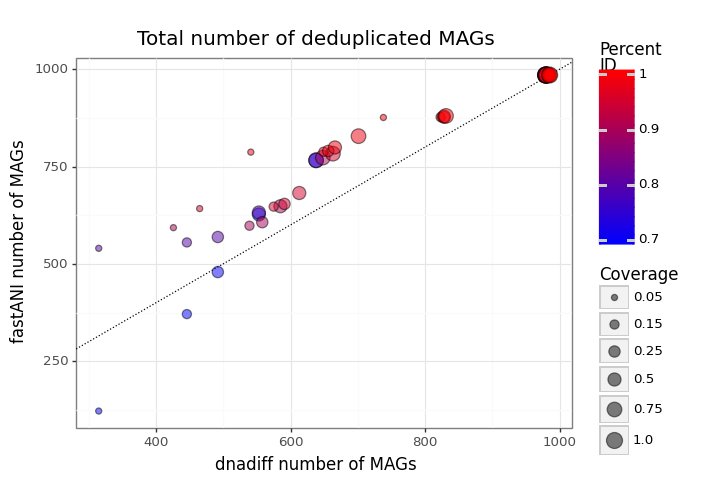

<ggplot: (2932306675134)>

In [26]:
final_output.Coverage=[str(curr) for curr in final_output.Coverage]
dnadiff_v_fastani = (plotnine.ggplot(final_output) + 
    plotnine.geom_abline(plotnine.aes(intercept=0,slope=1),linetype="dotted") + 
    plotnine.geom_point(plotnine.aes(x = "NumberDistinctMAGsMummer",
                                     y = "NumberDistinctMAGsFastANI",
                                     fill = "PercID",
                                     size = "Coverage"),alpha=0.5) +
    plotnine.theme_bw(base_size=12) + plotnine.ylab("fastANI number of MAGs") + 
    plotnine.xlab("dnadiff number of MAGs") + plotnine.scale_fill_gradient(name="Percent\nID",
                                                                            low="blue",
                                                                            high="red") + 
    plotnine.ggtitle("Total number of deduplicated MAGs"))
plotnine.ggsave(plot=dnadiff_v_fastani,filename="dnadiff_v_fastani.png")
dnadiff_v_fastani

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: mag_cover_compare.png


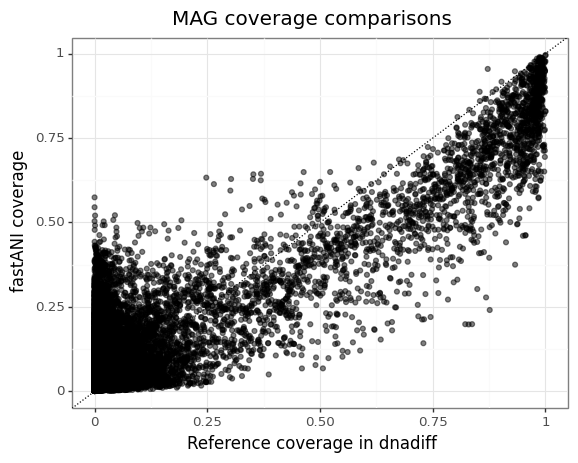

<ggplot: (2932306744016)>

In [27]:
mag_cover_compare = (plotnine.ggplot(compare_with_ani) + 
    plotnine.geom_abline(plotnine.aes(intercept=0,slope=1),linetype="dotted") + 
    plotnine.geom_point(plotnine.aes(x = "RefAlignCov", y = "perc_aligned"),alpha=0.5) +
    plotnine.theme_bw(base_size=12) + plotnine.ylab("fastANI coverage") + 
    plotnine.xlab("Reference coverage in dnadiff") + 
    plotnine.ggtitle("MAG coverage comparisons"))
plotnine.ggsave(plot=mag_cover_compare,filename="mag_cover_compare.png")
mag_cover_compare

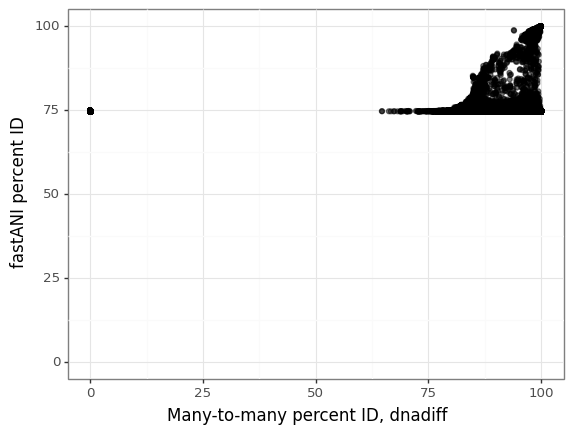

<ggplot: (2932307380206)>

In [12]:
(plotnine.ggplot(compare_with_ani) + 
    plotnine.geom_point(plotnine.aes(x = "ManyToManyPercID", y = "percid"),alpha=0.5) +
    plotnine.xlim([0,100]) + plotnine.ylim([0,100]) + 
    plotnine.theme_bw(base_size=12) + plotnine.ylab("fastANI percent ID") + 
    plotnine.xlab("Many-to-many percent ID, dnadiff"))